# Preparing job-listing dataset for data analysis
## Objectives:
- Import data from job search on Glassdoor for software engineering roles and tidy the values for analysis
- Provide example analysis to investigate:
1. Expected Salary vs Industry (in table form)
2. Company Revenue vs Company Size (plot)
3. Company Revenue vs Company Age for each industry (plot)

In [1]:
import pandas as pd
import numpy as np
import statistics as stat
import matplotlib.pyplot as plt
import seaborn as sns

job_list_csv = pd.read_csv('joblisting.csv')
print(job_list_csv.head())

   Unnamed: 0                       company  \
0           0                  Walmart\n3.4   
1           1                   TikTok\n3.8   
2           2                   Indeed\n4.3   
3           3                   Indeed\n4.3   
4           4  Thermo Fisher - America\n3.8   

                                           job title       headquarters  \
0                                     Data Scientist      Sunnyvale, CA   
1                                     Data Scientist  Mountain View, CA   
2  Principal Data Scientist - Candidate Recommend...  San Francisco, CA   
3     Senior Data Scientist - Moderation Engineering  San Francisco, CA   
4                                 Data Scientist III  San Francisco, CA   

                          salary estimate              job type  \
0                                      -1        Job Type : N/A   
1                                      -1  Job Type : Full-time   
2  Employer Provided Salary:$187K - $231K  Job Type : Full-time  

In [2]:
print(job_list_csv.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2573 entries, 0 to 2572
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       2573 non-null   int64 
 1   company          2573 non-null   object
 2   job title        2573 non-null   object
 3   headquarters     2573 non-null   object
 4   salary estimate  2573 non-null   object
 5   job type         2573 non-null   object
 6   size             2573 non-null   object
 7   founded          2573 non-null   int64 
 8   type             2573 non-null   object
 9   industry         2573 non-null   object
 10  sector           2573 non-null   object
 11  revenue          2573 non-null   object
 12  job description  2573 non-null   object
dtypes: int64(2), object(11)
memory usage: 261.4+ KB
None


In [3]:
#Column Headings
job_list = job_list_csv.rename(columns = {'job title':'job_title', 'headquarters':'hq', 'salary estimate':'salary_estimate', 'job type':'job_type','size':'company_size','job description':'job_description'})
job_list.index.names = ['id']


In [4]:
# 'Index' Column
job_list.drop(columns=['Unnamed: 0'], inplace=True)

In [5]:
# 'Company' Column
    
job_list.company = job_list.company.apply(lambda string : string.split('\n')[0] if '\n' in string else string)

## Check by hand for any visible typos
# print(np.sort(job_list.company.unique()))

In [6]:
# 'Job Title' Column

def correct_case(string):
    lower_string = string.lower()
    letters = list(lower_string)
    letters[0] = letters[0].upper()
    count = 0
    
    
    for i in letters:
        if i == ' ':
            letters[count+1] = letters[count+1].upper()
        count += 1
    
    corrected_string = ''.join(letters)
    
    return corrected_string

job_list.job_title = job_list.job_title.apply(correct_case)

# print(job_list.head())

In [7]:
# Re-arrange misplaced data spotted by exploring dataset values - this only affects listings with a job title
#  starting with 'Division of'

for i in range(1,len(job_list)-1):
    if job_list.loc[i].job_title[:8] == 'Division':
        job_list.loc[i,'job_title'] = job_list.loc[i,'hq']
        job_list.loc[i,'hq'] = job_list.loc[i,'salary_estimate']
        job_list.loc[i,'salary_estimate'] = '-1' #to match the existing missing data formatting


In [8]:
# 'Headquarters' Column - I want to separate the state from the city so this can be used to filter values
# print(job_list.hq.unique())

# def extract_state(string):
#     return string.split(',')[1]

job_list['hq_state'] = job_list.hq.apply(lambda x: x.split(', ')[1] if ',' in x else 'N/A')
job_list['hq_location'] = job_list.hq.apply(lambda x: x.split(', ')[0] if ',' in x else x)

job_list = job_list.iloc[:,[0,1,13,12,2,3,4,5,6,7,8,9,10,11]]

job_list.drop(columns=['hq'], inplace=True)

# print(job_list.head())

In [9]:
# 'Estimated Salary' Column - I want to separate this into 4 columns - min., max., type of salary (i.e. hourly or annual) 
#  and whether this is confirmed or estimated

def extract_salary(string):   
    num = string.count('$')
    
    if num == 0:
        salary_min = np.nan
        salary_max = np.nan
    
    elif num == 1:
        if 'K' in string:
            salary_min = int(string.split('$')[1].split('K')[0])*1000
            
        else:
            salary_min = int(string.split('$')[1])
            
        salary_max = salary_min

    elif num == 2:       
        if 'K' in string:
            salary_min = int(string.split('$')[1].split('K')[0])*1000
            salary_max = int(string.split('$')[2].split('K')[0])*1000
            
        else:
            salary_min = int(string.split('$')[1].split(' ')[0])
            salary_max = int(string.split('$')[2].split(' ')[0])

    return salary_min, salary_max

job_list['salary_min'] = job_list.salary_estimate.apply(lambda x: extract_salary(x)[0])

job_list['salary_max'] = job_list.salary_estimate.apply(lambda x: extract_salary(x)[1])

# Salary Type
job_list['salary_type'] = job_list.salary_estimate.apply(lambda x : 'hourly' if 'Per Hour' in x else \
                                                         ('unknown' if x == '-1' else 'annual'))

job_list.salary_type = pd.Categorical(job_list.salary_type,['hourly', 'annual'], ordered=False)

# Salary Confirmed?
job_list['salary_confirmed'] = job_list.salary_estimate.apply(lambda x : 'confirmed' if 'Provided' in x else ('estimated' if 'est' in x else 'unknown'))
job_list.salary_confirmed = pd.Categorical(job_list.salary_confirmed,['confirmed','estimated'], ordered=False)

#Reshuffle
job_list = job_list.iloc[:,[0,1,2,3,4,13,14,15,16,5,6,7,8,9,10,11,12]]

job_list.drop(columns=['salary_estimate'], inplace=True)

# print(job_list.loc[[110,111,112,113,114,115,973]])




In [10]:
# 'Job Type' Column
job_list.job_type = job_list.job_type.apply(lambda string: string.split('Job Type : ')[1])
job_list.job_type = job_list.job_type.apply(lambda string: 'unknown' if string == 'N/A' else string)
job_list.job_type = pd.Categorical(job_list.job_type,['unknown', 'Full-time', 'Part-time', 'Contract',\
                                                          'Internship', 'Temporary'], ordered=False)

# print(job_list.loc[[110,111,112,113,114,115,973]])
print(job_list.job_type.unique())

['unknown', 'Full-time', 'Part-time', 'Contract', 'Internship', 'Temporary']
Categories (6, object): ['unknown', 'Full-time', 'Part-time', 'Contract', 'Internship', 'Temporary']


In [11]:
# 'Size' Column

job_list.company_size = job_list.company_size.apply(lambda string: 'unknown' if string == '-1' else string)

job_list.company_size = pd.Categorical(job_list.company_size,['unknown','1 to 50 employees','51 to 200 employees',\
                                                           '201 to 500 employees', '501 to 1000 employees', \
                                                            '1001 to 5000 employees', '5001 to 10000 employees',\
                                                           '10000+ employees'], ordered=True)

print(job_list.company_size.unique())

['10000+ employees', '501 to 1000 employees', 'unknown', '201 to 500 employees', '5001 to 10000 employees', '51 to 200 employees', '1001 to 5000 employees', '1 to 50 employees']
Categories (8, object): ['unknown' < '1 to 50 employees' < '51 to 200 employees' < '201 to 500 employees' < '501 to 1000 employees' < '1001 to 5000 employees' < '5001 to 10000 employees' < '10000+ employees']


In [12]:
# 'Revenue' Column

job_list.revenue = job_list.revenue.apply(lambda x: 'unknown' if x == '-1' or x == 'unknown / non-applicable' or x == np.nan else x)


job_list.revenue = pd.Categorical(job_list.revenue,['unknown','less than $1 million (usd)','$1 to $5 million (usd)',\
                                                           '$5 to $10 million (usd)', '$10 to $25 million (usd)', \
                                                            '$25 to $50 million (usd)', '$50 to $100 million (usd)',\
                                                           '$100 to $500 million (usd)', '$500 million to $1 billion (usd)',\
                                                            '$1 to $2 billion (usd)', '$2 to $5 billion (usd)', \
                                                            '$5 to $10 billion (usd)', '$10+ billion (usd)'], ordered=True)

print(list(job_list.revenue.unique()))


['$10+ billion (usd)', 'unknown', '$2 to $5 billion (usd)', '$1 to $2 billion (usd)', '$500 million to $1 billion (usd)', '$25 to $50 million (usd)', '$5 to $10 billion (usd)', '$50 to $100 million (usd)', 'less than $1 million (usd)', '$100 to $500 million (usd)', '$10 to $25 million (usd)', '$5 to $10 million (usd)', '$1 to $5 million (usd)']


In [13]:
# 'Type' Column

job_list.type = job_list.type.apply(lambda x: 'unknown' if x == '-1' else x)

job_list.type = pd.Categorical(job_list.type,['company - public', 'company - private', 'unknown',\
                                              'nonprofit organization', 'government', 'subsidiary or business segment',\
                                              'contract', 'self-employed', 'private practice / firm',\
                                              'college / university', 'hospital', 'school / school district'], ordered=False)

print(job_list.type.unique())

['company - public', 'company - private', 'unknown', 'nonprofit organization', 'government', ..., 'self-employed', 'private practice / firm', 'college / university', 'hospital', 'school / school district']
Length: 12
Categories (12, object): ['company - public', 'company - private', 'unknown', 'nonprofit organization', ..., 'private practice / firm', 'college / university', 'hospital', 'school / school district']


In [14]:
# Remaining columns - mostly formatting and replacing the -1's with 'unknown'

job_list.founded = job_list.founded.apply(lambda x: np.nan if x == -1 else x)
job_list.industry = job_list.industry.apply(lambda x: 'unknown' if x == '-1' else x)
job_list.sector = job_list.sector.apply(lambda x: 'unknown' if x == '-1' else x)
job_list.job_description = job_list.job_description.apply(lambda string : string.replace('\n',' ') if '\n' in string else string)

# print(job_list.head())

job_list.info()

job_list.to_csv('clean_job_list.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2573 entries, 0 to 2572
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   company           2573 non-null   object  
 1   job_title         2573 non-null   object  
 2   hq_location       2573 non-null   object  
 3   hq_state          2573 non-null   object  
 4   salary_min        2095 non-null   float64 
 5   salary_max        2095 non-null   float64 
 6   salary_type       2095 non-null   category
 7   salary_confirmed  2095 non-null   category
 8   job_type          2573 non-null   category
 9   company_size      2573 non-null   category
 10  founded           1921 non-null   float64 
 11  type              2573 non-null   category
 12  industry          2573 non-null   object  
 13  sector            2573 non-null   object  
 14  revenue           2573 non-null   category
 15  job_description   2573 non-null   object  
dtypes: category(6), float64(

In [15]:
# Basic comparison of the salaries for different industries

industry_vs_salary = job_list[['salary_min', 'salary_max', 'salary_type', 'salary_confirmed', 'industry']]

# I've decided to remove unknown salary data from the analysis rather than fill with a different value

industry_vs_salary = industry_vs_salary.dropna(how='any')

# Also removing data given as hourly rates as this is a small number of entries and there is not enough information to
## equate this to the annual salaries

industry_vs_salary = industry_vs_salary[industry_vs_salary.salary_type=='annual']

# For demonstration I'll generate a salary estimate using the mean of the min and max for each and compare this,
## for a more detailed analysis in future I would leave min and max separate to explore the differences

industry_vs_salary['salary_est'] = industry_vs_salary.apply(lambda row: stat.mean([row.salary_min, row.salary_max]), axis=1)

industry_vs_salary_mean = industry_vs_salary.groupby('industry').salary_est.mean().reset_index()

industry_vs_salary_mean.reset_index(drop=True, inplace=True)

# Add number of instances for additional context
counts = job_list.industry.value_counts().reset_index()
counts.rename(columns={'index':'industry', 'industry':'count'}, inplace=True)
industry_vs_salary_mean = pd.merge(industry_vs_salary_mean,counts, on="industry")


industry_vs_salary_mean.sort_values(by=['salary_est'], ascending = False, inplace=True)
industry_vs_salary_mean.reset_index(inplace=True, drop=True)


pd.set_option('display.max_rows', 100)

print(industry_vs_salary_mean)


                                    industry     salary_est  count
0                               ticket sales  157500.000000      2
1              building & personnel services  154500.000000      1
2              tv broadcast & cable networks  152500.000000      2
3                                   trucking  149900.000000      5
4                                   internet  148966.453674    364
5                                video games  147041.666667     16
6                            stock exchanges  146500.000000      1
7      investment banking & asset management  145500.000000     22
8     transportation equipment manufacturing  145125.000000     34
9                         brokerage services  143666.666667      6
10                       other retail stores  143500.000000     32
11                                   lending  142333.333333     17
12         general merchandise & superstores  141413.043478     29
13                                     radio  141375.000000   

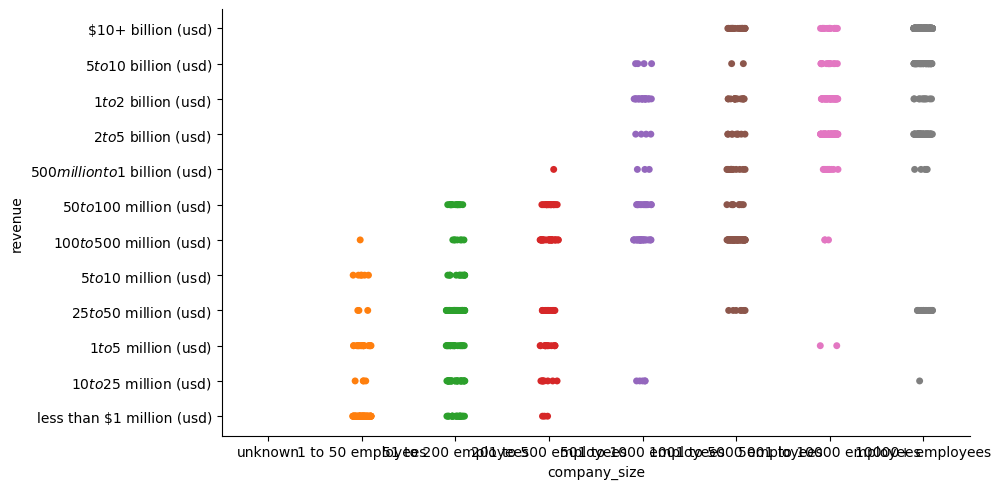

In [16]:
# Revenue vs Company Size for demo purposes (2no. categorical datasets)
plt.close()

# growth_vs_industry = job_list[['size',]]
revenue_vs_size = job_list[job_list.revenue != 'unknown']
revenue_vs_size = revenue_vs_size[revenue_vs_size.company_size != 'unknown']

sns.catplot(data=revenue_vs_size,x='company_size', y='revenue', height=5, aspect=2)
plt.show()

## As expected, generally, the larger the company in size the higher its revenue

['computer hardware & software', 'internet', 'biotech & pharmaceuticals', 'it services', 'enterprise software & network solutions', 'staffing & outsourcing']


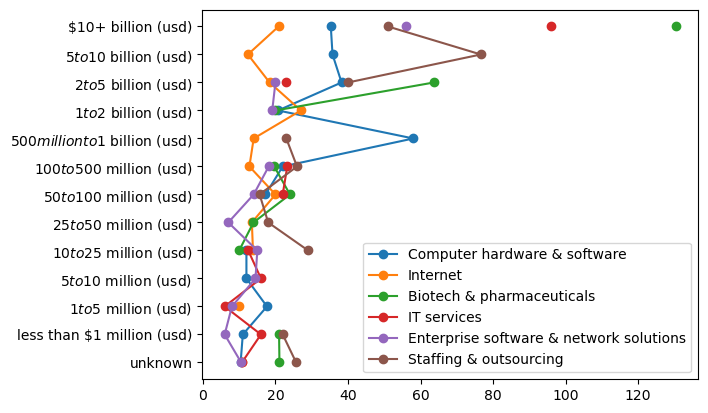

In [17]:
# Company age vs revenue vs industry
age_vs_revenue = job_list[['founded', 'industry', 'revenue']]

## This is kicking up an error but I'm unsure why:
#age_vs_revenue['company_age'] = age_vs_revenue.founded.apply(lambda x : 2023 - x)

# Instead:
c_age = pd.DataFrame()
c_age['company_age'] = age_vs_revenue.founded.apply(lambda x : 2023 - x)

age_vs_revenue = age_vs_revenue.merge(c_age, left_index=True, right_index=True)

# print(age_vs_revenue.head())
# print(type(age_vs_revenue.industry.value_counts()))

# I'm only going to compare the industries with over 50 datapoints as these should give me a good trendline and it'll
## it'll make my graph look prettier
ind_counts = age_vs_revenue.industry.value_counts()
ind_counts.drop('unknown',inplace=True)

ind_shortlist = list(ind_counts[ind_counts>100].index)
# print(ind_shortlist)

avr_plotdata = age_vs_revenue[age_vs_revenue.industry.isin(ind_shortlist)].sort_values(by='company_age')

avr_plotdata_1 = avr_plotdata[avr_plotdata.industry == 'computer hardware & software']
avr_plotdata_2 = avr_plotdata[avr_plotdata.industry == 'internet']
avr_plotdata_3 = avr_plotdata[avr_plotdata.industry == 'biotech & pharmaceuticals']
avr_plotdata_4 = avr_plotdata[avr_plotdata.industry == 'it services']
avr_plotdata_5 = avr_plotdata[avr_plotdata.industry == 'enterprise software & network solutions']
avr_plotdata_6 = avr_plotdata[avr_plotdata.industry == 'staffing & outsourcing']


## Tried plotting this as is, but the data was too congested to get any meaningful information

## Instead, I will plot the mean age for each revenue bracket and compare these
avr_plotdata_1 = avr_plotdata_1.groupby('revenue').company_age.mean().reset_index()
avr_plotdata_2 = avr_plotdata_2.groupby('revenue').company_age.mean().reset_index()
avr_plotdata_3 = avr_plotdata_3.groupby('revenue').company_age.mean().reset_index()
avr_plotdata_4 = avr_plotdata_4.groupby('revenue').company_age.mean().reset_index()
avr_plotdata_5 = avr_plotdata_5.groupby('revenue').company_age.mean().reset_index()
avr_plotdata_6 = avr_plotdata_6.groupby('revenue').company_age.mean().reset_index()

plt.close()
plt.plot(avr_plotdata_1.company_age, avr_plotdata_1.revenue, label='Computer hardware & software',marker='o',linestyle='-')
plt.plot(avr_plotdata_2.company_age, avr_plotdata_2.revenue, label='Internet', marker='o',linestyle='-')
plt.plot(avr_plotdata_3.company_age, avr_plotdata_3.revenue, label='Biotech & pharmaceuticals', marker='o',linestyle='-')
plt.plot(avr_plotdata_4.company_age, avr_plotdata_4.revenue, label='IT services', marker='o',linestyle='-')
plt.plot(avr_plotdata_5.company_age, avr_plotdata_5.revenue, label='Enterprise software & network solutions', marker='o',linestyle='-')
plt.plot(avr_plotdata_6.company_age, avr_plotdata_6.revenue, label='Staffing & outsourcing', marker='o',linestyle='-')
plt.legend()
plt.show()


## I wanted to get an indication of the industry in which the companies grow fastest i.e. reach the highest revenue
### brackets at the youngest age - It's difficult to draw any strong conclusions from this, however it looks as though
#### companies in the Internet and Enterprise Software industry grow the fastest while Biotech & Pharma companies tend 
##### to grow at the slowest rate of the sampled industries

